# HKBU COMP7015 Aritificial Intelligence mini project

## Group members :  
* 1) **Name:** XU YU        **Student ID:** 20416601  **Mark:** Liaison
* 2) **Name:** <u>LI WEIJIE</u>     **Student ID:** <u>20416644</u>
* 3) **Name:** <u>LIN JUANJIA</u>    **Student ID:** <u>20430779</u>

## Project code 

### 1) Import dependent package

In [1]:
import pandas as pd
import numpy as np
import operator

### 2) Data Pre-progress

#### Read iris dataset as dataframe

In [2]:
df = pd.read_csv("iris.csv",header=0,sep=',')

####  Random permutation for data 

In [3]:
row_index = np.random.permutation(df.shape[0]) # random rows ,return rows index

#### Divide dataset to training set and testing set

In [4]:
divide = int(0.8* len(row_index)) # 80% as training data, 20% as test data
training_index=row_index[:divide]
test_index=row_index[divide:]

training_set = df.iloc[training_index,:4].values   # all data transform to be np.array ,avoid the further possible error
test_set = df.iloc[test_index,:4].values

#### Divide class labels

In [5]:
training_class = df.iloc[training_index,4].values
test_class = df.iloc[test_index,4].values

### 3) KNN functions, using euclideanDistance

In [6]:
class KNN():
    
    def __init__(self,TrainSet,TrainLabel,TestData,K_value):
        self.predictValue = self.Predict(TrainSet,TrainLabel,TestData,K_value)

    def euclideanDistance(self,point_1, point_2, data_len):
        distance = 0
        for i in range(data_len): # multip-attributes
            distance = distance + np.square(point_1[i] - point_2[i])
        return np.sqrt(distance) # root the square value.
    
    def Predict(self,train_dataset,train_class,test_datapoint,k):
        distances={} # dict type key: value
        neighbors = [] # store nearest k values, list type
        
        # Distance calculation 
        for x in range(len(train_dataset)):
            dist_temp = self.euclideanDistance(test_datapoint, train_dataset[x], len(test_datapoint))
            distances[x] = dist_temp
            
        # Ordering distances by ascending
        sorted_distances = sorted(distances.items(),key=operator.itemgetter(1))# operator.itemgetter(1) , aim to [0]:[1] for dict type
        
        for x in range(k):  # range(k)
            neighbors.append(sorted_distances[x][0]) # get the index of k-nearest points
        
        # Voting majority in k-points
        count_points = {"Iris-setosa" : 0, "Iris-versicolor" : 0, "Iris-virginica" : 0}

        for x in range(len(neighbors)):
           
            response_class = train_class[neighbors[x]] # using index to get class label of neighbor data in training dataset
            if response_class in count_points:
                count_points[response_class] += 1 # count number
            else:
                count_points[response_class] = 1 # not in our target class
           
        sorted_count_points = sorted(count_points.items(), key=operator.itemgetter(1), reverse=True) # find the most frequent class(get major points during these k points)
        
        return sorted_count_points[0][0]  # return predict result 
    
    def PredictResult(self):
        return self.predictValue

### 4) Principal Components Analysis

In [7]:
class PCA():
    
    def __init__(self):
        self.std_num = 1
    
    def Projector(self,row_data, PCs):
        data = row_data/self.std_num
        S = np.cov(data.T) # calculate covariance
        eigvalues,eigvectors = np.linalg.eig(S) # get eigenvalues&vectors
        indexByValues = np.argsort(eigvalues)[::-1] # sort the top max eigenvalue
    
        eigvalues,eigvectors = eigvalues[indexByValues],eigvectors[:,indexByValues] # with the paired eigenvectors
        eigvalues=np.real(eigvalues)
        eigvectors=np.real(eigvectors)
        subspace = data @ eigvectors[:,:PCs] 
        return eigvalues,eigvectors,subspace

    def Reconstruct(self, data, eig_vectors,PCs):
        eig_vectors = eig_vectors[:,:PCs]
        cover_data = data @ eig_vectors.T
        cover_data = self.std_num * cover_data

        return cover_data

### 5) K-fold Cross Validation

In [8]:
def K_fold(dataset,folds,testSet_index):
    
    # subset size
    subset_capicity=(int)(dataset.shape[0]/folds)
    
    # divide into k folds 
    stage = 0
    subset_kfold = []# store [fold1,fold2,,,foldn]
    for i in range(folds):
        subset_kfold.append(dataset[stage:(subset_capicity+stage),:])
        stage += subset_capicity
    
    # testing dataset
    if(testSet_index<folds):
        test_sample = subset_kfold.pop(testSet_index)  
    else: return "over index"
    
    # training dataset
    train_sample = np.array([])
    train_sample=subset_kfold[0] # make arrary dimensions to be same for toolbox np.concatenate function require
    for i in range(folds-2):
        train_sample=np.concatenate((train_sample,subset_kfold[i+1])) 
    
    return test_sample,train_sample

## Performance Test

#### Simple test with *K-value =5* and *K-value =10*

In [9]:
# k-value =5
NumTest=test_set.shape[0]
Right = 0
for i in range(NumTest):
    testpoint = test_set[i]
    Test= KNN(training_set,training_class,testpoint,5)

    if test_class[i] == Test.PredictResult() :
        Right += 1

print("Accuary: %f%% ,Number of test samples: %d, K-value: %d"% ((Right/NumTest)*100,NumTest,5))

# k-value = 10
Right = 0
for i in range(NumTest):
    testpoint = test_set[i]
    Test= KNN(training_set,training_class,testpoint,10)

    if test_class[i] == Test.PredictResult() :
        Right += 1

print("Accuary: %f%% ,Number of test samples: %d, K-value: %d"% ((Right/NumTest)*100,NumTest,10))

Accuary: 93.333333% ,Number of test samples: 30, K-value: 5
Accuary: 96.666667% ,Number of test samples: 30, K-value: 10


#### Simple test with PCA, PCs=2

In [10]:
p=PCA()
e_values,e_vectors,subset= p.Projector(training_set,2)
subset_test = test_set  @ e_vectors[:,:2]
print("Raw Data shape:",training_set.shape)
print("After PCA Data shape:",subset.shape)

NumTest=test_set.shape[0]
Right = 0
for i in range(NumTest):
    testpoint = subset_test[i]
    Test= KNN(subset,training_class,testpoint,5)

    if test_class[i] == Test.PredictResult() :
        Right += 1

print("Accuary: %f%% ,Number of test samples: %d, K-value: %d, PCs:%d"% ((Right/NumTest)*100,NumTest,5,2))

Right = 0
for i in range(NumTest):
    testpoint = subset_test[i]
    Test= KNN(subset,training_class,testpoint,10)

    if test_class[i] == Test.PredictResult() :
        Right += 1

print("Accuary: %f%% ,Number of test samples: %d, K-value: %d, PCs:%d"% ((Right/NumTest)*100,NumTest,10,2))


Raw Data shape: (120, 4)
After PCA Data shape: (120, 2)
Accuary: 93.333333% ,Number of test samples: 30, K-value: 5, PCs:2
Accuary: 93.333333% ,Number of test samples: 30, K-value: 10, PCs:2


### Choosing best K-value of KNN by using K-folds  
The lowest point in the graph has the lowest test error-rate  
If it's regression problem,we could use MSE replace missclassification times

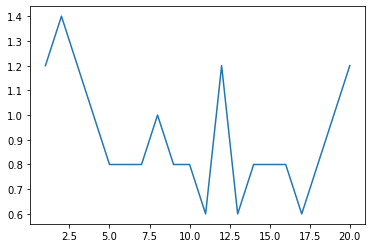

In [11]:
#dataset_ = df.values # 
dataset_ = df.iloc[row_index].values
fold=5
Err_list =[]
for z in range(1,21):  # K-value range
    
    Sum=0 # every K-value's test error
    for j in range(fold): # different testset from dataset
        # Get subsets
        test_samples,train_samples=K_fold(dataset_,fold,j)
        test_set = test_samples[:,:4]
        train_set = train_samples[:,:4]
        test_label = test_samples[:,4]
        train_label =train_samples[:,4]
        # Reset counts
        Right = 0
        Err = 0 
        for i in range(len(test_set)): # one-time KNN, one 'for' loop a testset
            testpoint = test_set[i]
            Test= KNN(train_set,train_label,testpoint,z)

            if test_label[i] == Test.PredictResult() :
                Right += 1
            Err=NumTest-Right
        #print("Accuary: %f%% ,Number of test samples: %d, K-value: %d,K-folds:%d, Misscla:%d"% ((Right/NumTest)*100,NumTest,z,j,Err))
        Sum+=Err
        
    Err_list.append(Sum/fold) # K-fold average error
    
import matplotlib.pyplot as plt

x = list(range(1,21))
plt.plot(x,Err_list)


## References  

[1]Python Numpy Array Tutorial. (n.d.). Retrieved from https://www.datacamp.com/community/tutorials/python-numpy-tutorial

[2]James, Gareth, Witten, Daniela, Hastie, Trevor, & Tibshirani, Robert. (2013). An introduction to statistical learning (Vol. 103, Springer texts in statistics). New York: Springer.

[3]Carlsen, L., & Bruggemann, R. (2020). The iris dataset revisited – a partial ordering study. Informatica, 44(1), 35-44. doi:http://dx.doi.org.lib-ezproxy.hkbu.edu.hk/10.31449/inf.v44i1.2715

[4]Principal Component Analysis. (n.d.). Retrieved from https://plot.ly/ipython-notebooks/principal-component-analysis/

[5]How to Calculate Principal Component Analysis (PCA) from Scratch in Python. (2019, May 30). Retrieved from https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

[6]k-NN, Logistic Regression, k-Fold CV from Scratch. Retrieved from https://www.kaggle.com/burhanykiyakoglu/k-nn-logistic-regression-k-fold-cv-from-scratch